In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import transforms
from torchinfo import summary

from dataset import MnistDataset
import training as f
from vae import VAE

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [3]:
BATCH_SIZE = 256

N_PIXELS = 28 * 28
LATENT_SIZE = 32
N_NEURONS = 64

LR = 2e-3
EPOCHS = 50
MAX_PATIENCE = 5

In [4]:
t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_data = MnistDataset('train', t)
val_data = MnistDataset('val', t)
test_data = MnistDataset('test', t)

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)

In [5]:
result_dir = 'results/'
name = 'vae'

In [6]:
likelihood_type = 'categorical'
num_vals = 256

encoder = nn.Sequential(
    nn.Linear(N_PIXELS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, 2 * LATENT_SIZE)
).to(device)

decoder = nn.Sequential(
    nn.Linear(LATENT_SIZE, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, N_NEURONS), nn.LeakyReLU(),
    nn.Linear(N_NEURONS, num_vals * N_PIXELS)
).to(device)

model = VAE(encoder, decoder, num_vals, LATENT_SIZE, likelihood_type).to(device)

# Print summary
print("ENCODER:\n", summary(encoder, (N_PIXELS,)))
print("\nDECODER:\n", summary(decoder, (LATENT_SIZE,)))

ENCODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64]                      --
├─Linear: 1-1                            [64]                      50,240
├─LeakyReLU: 1-2                         [64]                      --
├─Linear: 1-3                            [64]                      4,160
├─LeakyReLU: 1-4                         [64]                      --
├─Linear: 1-5                            [64]                      4,160
Total params: 58,560
Trainable params: 58,560
Non-trainable params: 0
Total mult-adds (M): 3.75
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.23
Estimated Total Size (MB): 0.24

DECODER:
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [200704]                  --
├─Linear: 1-1                            [64]                      2,112
├─LeakyReLU: 1-2                         [64]  

In [7]:
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=LR)

nll_val = f.training(device, result_dir + name, MAX_PATIENCE, EPOCHS, model, optimizer, train_loader, val_loader)

Epoch: 0, val nll=278.18104790039064
Epoch: 1, val nll=264.39108134765627
Epoch: 2, val nll=254.473930078125
Epoch: 3, val nll=245.957012109375
Epoch: 4, val nll=240.48645480957032
Epoch: 5, val nll=233.91567971191407
Epoch: 6, val nll=223.31510095214844
Epoch: 7, val nll=214.1271071777344
Epoch: 8, val nll=208.03117578125
Epoch: 9, val nll=203.31852465820313
Epoch: 10, val nll=198.96495043945313
Epoch: 11, val nll=195.70074140625
Epoch: 12, val nll=191.42000708007814
Epoch: 13, val nll=187.49364526367188
Epoch: 14, val nll=184.2649427734375
Epoch: 15, val nll=181.0621583984375
Epoch: 16, val nll=178.46038427734376
Epoch: 17, val nll=175.531678125
Epoch: 18, val nll=173.29386579589843
Epoch: 19, val nll=171.54027783203125
Epoch: 20, val nll=169.5643091064453
Epoch: 21, val nll=167.84820302734374
Epoch: 22, val nll=166.41240859375
Epoch: 23, val nll=165.18514516601562
Epoch: 24, val nll=163.92163386230467
Epoch: 25, val nll=162.635880078125
Epoch: 26, val nll=161.84363813476563
Epoch: 2

FINAL LOSS: nll=147.30714653320314


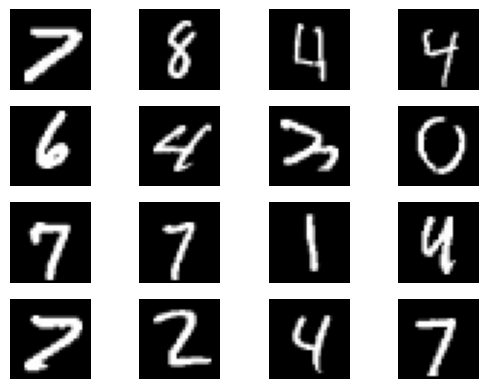

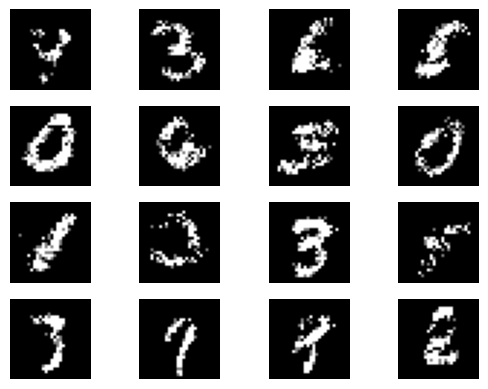

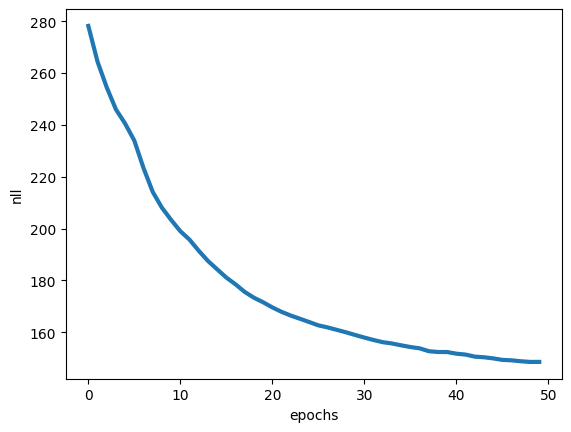

In [8]:
test_loss = f.evaluation(device, test_loader, name=result_dir+name)
file = open(result_dir+name + '_test_loss.txt', 'w')
file.write(str(test_loss))
file.close()

f.samples_real(result_dir + name, test_loader)
f.samples_generated(result_dir + name)

f.plot_curve(result_dir + name, nll_val)